In [2]:
from transformers import LlamaForCausalLM, LlamaTokenizer, pipeline, LlamaModel, LlamaConfig
import re
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
import math
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from accelerate import Accelerator, notebook_launcher # main interface, distributed launcher
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

2024-05-28 20:42:35.037079: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 20:42:35.037190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 20:42:35.154693: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Tokenizer
The tokenizer splits the text string into individual words and subwords, called **tokens**. Each token is mapped to a **unique** identifier. In this way, the human-readable text is converted into a form that the LLM can process efficiently. The dataset is divided into 50,000 intervals, and each value is subsequently mapped to the new domain.

In [3]:
class Tokenizer(nn.Module):
    def __init__(self, voc_size, lower_bound, upper_bound):
        super(Tokenizer, self).__init__()
        self.voc_size = voc_size
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.discrete_values = torch.linspace(self.lower_bound, self.upper_bound, self.voc_size).to('cuda')

    def forward(self, dataset_std):
        dataset_std = dataset_std.contiguous()
        quantized_values = torch.bucketize(dataset_std, self.discrete_values) + 2
        attention_mask = (~torch.isnan(dataset_std))
        return quantized_values, attention_mask

### Patch embedding layer
The series is split in many patches with fixed length. The patches are padded and strided, repeating the last value to emphasize it. The embedding vectors are computed through a 1D convolution.

In [4]:
class ReplicationPad1d(nn.Module):
    def __init__(self, padding):
        super(ReplicationPad1d, self).__init__()
        self.padding = padding

    def forward(self, x):
        replicate_padding = x[:, :, -1].unsqueeze(-1).repeat(1, 1, self.padding[-1])
        return torch.cat([x, replicate_padding], dim=-1)


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in,
                                   out_channels=d_model,
                                   kernel_size=3,
                                   padding=padding,
                                   padding_mode='circular',
                                   bias=False)

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_in',
                                        nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1).float()).transpose(1, 2)
        return x


class PatchEmbeddings(nn.Module):

    def __init__(self, d_model, patch_len, stride, dropout):
        super(PatchEmbeddings, self).__init__()

        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch_layer = ReplicationPad1d((0, stride))

        self.value_embedding = TokenEmbedding(patch_len, d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        n_vars = x.shape[1]
        x = self.padding_patch_layer(x)
        x = x.unfold(dimension=-1, size=self.patch_len, step=self.stride)
        x = torch.reshape(x, (x.shape[0]*x.shape[1], x.shape[2], x.shape[3]))

        x = self.value_embedding(x)
        return self.dropout(x)

### Attention layer
The attention layer assigns a score to embedding token related to its importance in the context.

In [5]:
class Attention(nn.Module):

    def __init__(self, d_model, d_llm=None, attention_dropout=0.1):
        super(Attention, self).__init__()
        n_heads = 8
        d_keys = d_model // n_heads
        self.query_projection = nn.Linear(d_model, d_model)
        self.key_projection = nn.Linear(d_llm, d_model)
        self.value_projection = nn.Linear(d_llm, d_model)
        self.out_projection = nn.Linear(d_model, d_llm)
        self.n_heads = n_heads
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, target, source, value):
        B, L, _ = target.shape
        S, _ = source.shape
        H = self.n_heads

        target = self.query_projection(target).view(B, L, H, -1)
        source = self.key_projection(source).view(S, H, -1)
        value = self.value_projection(value).view(S, H, -1)
        out = self.reprogram(target, source, value).reshape(B, L, -1)

        return self.out_projection(out)

    def reprogram(self, target, source, value):
        B, L, H, E = target.shape

        scale = 1. / math.sqrt(E)

        scores = torch.einsum("blhe,she->bhls", target, source)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        reprogramming_embedding = torch.einsum("bhls,she->blhe", A, value)

        return reprogramming_embedding

### Feed-Forward Neural Network
A **Feed-Forward Neural Network** is trained to map the attention embedding to the predicted value, acting as a detokenizer.

In [6]:
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
class FlattenHead(nn.Module):
    def __init__(self, nf, target_window, head_dropout=0.1):
        super().__init__()
        self.flatten = nn.Flatten(start_dim=-2)
        self.linear = nn.Linear(nf, target_window)
        self.dropout = nn.Dropout(head_dropout)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        x = self.dropout(x)
        return x


In [8]:
def train_valid_loop(num_epochs, model, train_load, valid_load, n_in, n_pred):
    accelerator = Accelerator()

    MSE = nn.MSELoss()
    MAE = nn.L1Loss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    lr_scheduler = OneCycleLR(
        optimizer=optimizer,
        max_lr=3e-2,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader)
    )

    train_load, valid_load, model, optimizer, lr_scheduler = accelerator.prepare(
        train_load, valid_load, model, optimizer, lr_scheduler
    )

    earlystopper = EarlyStopping(verbose=True)

    train_losses_mse = []
    valid_losses_mse = []
    train_losses_mae = []
    valid_losses_mae = []

    for epoch in range(num_epochs):
        print('epoch', epoch)
        model.train()
        batch_train_losses_mse = []
        batch_train_losses_mae = []
        batch_valid_losses_mse = []
        batch_valid_losses_mae = []

        for train_data in tqdm(train_load):
            train_inputs, train_next_values = train_data[:, :n_in], train_data[:, -n_pred:]
            train_pred = model(train_inputs, n_pred).squeeze()
            train_loss_mse = MSE(train_pred.to('cuda'), train_next_values.to('cuda'))
            train_loss_mae = MAE(train_pred.to('cuda'), train_next_values.to('cuda'))
            batch_train_losses_mse.append(train_loss_mse)
            batch_train_losses_mae.append(train_loss_mae)

            accelerator.backward(train_loss_mse)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        model.eval()
        with torch.no_grad():
            for valid_data in tqdm(valid_load):
                valid_inputs, valid_next_values = valid_data[:, :n_in], valid_data[:, -n_pred:]
                valid_pred = model(valid_inputs, n_pred).squeeze()
                valid_loss_mse = MSE(valid_pred, valid_next_values)
                valid_loss_mae = MAE(valid_pred, valid_next_values)
                batch_valid_losses_mse.append(valid_loss_mse)
                batch_valid_losses_mae.append(valid_loss_mae)

        epoch_train_loss_mse = torch.Tensor(batch_train_losses_mse).mean().item()
        epoch_valid_loss_mse = torch.Tensor(batch_valid_losses_mse).mean().item()
        epoch_train_loss_mae = torch.Tensor(batch_train_losses_mae).mean().item()
        epoch_valid_loss_mae = torch.Tensor(batch_valid_losses_mae).mean().item()

        train_losses_mse.append(epoch_train_loss_mse)
        valid_losses_mse.append(epoch_valid_loss_mse)
        train_losses_mae.append(epoch_train_loss_mae)
        valid_losses_mae.append(epoch_valid_loss_mae)

        earlystopper(epoch_valid_loss_mse, model)
        if earlystopper.early_stop:
            break

    accelerator.wait_for_everyone()
    model = accelerator.unwrap_model(model)
    torch.save(timeSeriesNet.state_dict(), 'timeSeriesTrained.pth')

    # Plotting the training and validation losses
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses_mse, label='Training MSE', color='tab:red')
    plt.plot(valid_losses_mse, label='Validation MSE', color='tab:blue')
    plt.legend(loc='upper right')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation MSE Loss')
    
    
    plt.yticks(fontsize=12, alpha=.7)
    plt.xticks(fontsize=12, alpha=.7)
    plt.grid(axis='both', alpha=.3)

    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.3)

    plt.subplot(1, 2, 2)
    plt.plot(train_losses_mae, label='Training MAE')
    plt.plot(valid_losses_mae, label='Validation MAE')
    plt.legend(loc='upper right')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation MAE Loss')
    
    
    plt.yticks(fontsize=12, alpha=.7)
    plt.xticks(fontsize=12, alpha=.7)
    plt.grid(axis='both', alpha=.3)

    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.3)
    
    plt.savefig('/kaggle/working/training.png', dpi=300)
    plt.tight_layout()
    plt.show()

In [9]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


In [10]:
class Network(nn.Module):
    def __init__(self, voc_size, lower_bound, upper_bound, L, embedding_dim):
        super(Network, self).__init__()
        self.voc_size = voc_size
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.embedding_dim = embedding_dim
        self.d_llm = 768
        self.df_len = L

        MODEL_ID = "TaylorAI/Flash-Llama-30M-48001"
#         MODEL_ID = "/leonardo_scratch/large/userexternal/gesposit/models/Maykeye/TinyLlama-v0"
#         MODEL_ID = "/leonardo_scratch/large/userexternal/gesposit/models/TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"
#         MODEL_ID = "/leonardo_scratch/large/userexternal/gesposit/models/Llama-2-7b-hf/"
        self.llama_config = LlamaConfig.from_pretrained(MODEL_ID)
        self.model = LlamaModel.from_pretrained(
            MODEL_ID,
            config = self.llama_config
        )
        for param in self.model.parameters():
            param.requires_grad = False

        self.origin_embeddings = self.model.get_input_embeddings().weight
        self.vocab_size = self.origin_embeddings.shape[0]
        self.num_tokens = 1000

        self.mapping_layer = nn.Linear(self.vocab_size, self.num_tokens)

        self.tokenizer = Tokenizer(self.voc_size, self.lower_bound, self.upper_bound)
        self.patchEmbeddings = PatchEmbeddings(self.embedding_dim, 8, 8, .1)
        self.attention = Attention(self.embedding_dim, self.d_llm)
        self.patch_nums = int((256 - 8) / 8 + 2)
        self.head_nf = 8 * self.patch_nums
        self.output_projection = FlattenHead(self.head_nf, 48,
                                        head_dropout=.1)
        self.fc = FFNN(self.d_llm, 64, 1)

    def forward(self, in_values, n_pred):
#         inputs, att_mask = self.tokenizer(in_values)
#         inputs = inputs.unsqueeze(dim=1)   
        inputs = in_values.unsqueeze(dim=1)
        source_embeddings = self.mapping_layer(self.origin_embeddings.to(torch.float32).permute(1, 0)).permute(1, 0)
        emb = self.patchEmbeddings(inputs)
        att_emb = self.attention(emb, source_embeddings, source_embeddings)
        out_lhs = self.model(inputs_embeds = att_emb).last_hidden_state.squeeze() # -> return the embeddings as output
        out_lhs = out_lhs[:, :, :8]
        out_lhs = torch.reshape(
            out_lhs, (-1, 1, out_lhs.shape[-2], out_lhs.shape[-1]))
        out_lhs = out_lhs.permute(0, 1, 3, 2).contiguous()
        out_lhs = self.output_projection(out_lhs[:, :, :, -self.patch_nums:])
        out_lhs = out_lhs.permute(0, 2, 1).contiguous()
        return out_lhs



In [11]:
dataset = pd.read_csv('/kaggle/input/etth11/ETTh1.csv')
dataset.drop(columns=['date'], inplace=True)
scaler = StandardScaler()
df_hufl = dataset['HUFL']
hufl = torch.Tensor(df_hufl)
hufl = torch.Tensor(scaler.fit_transform(hufl.unsqueeze(dim=1)).squeeze())

In [12]:
n_in = 256
n_pred = 48
train_size = 0.8
validation_size = 0.1 
test_size = 0.1
window_size = n_in + n_pred  

In [13]:
num_windows = len(hufl) - window_size + 1

win = torch.zeros(num_windows, window_size)

for i in range(num_windows):
    w = hufl[i:i+window_size]
    win[i] = w

win.shape

torch.Size([17117, 304])

In [14]:
train_len = int(train_size * len(win))
validation_len = int(validation_size * len(win))
test_len = int(test_size * len(win))

train_win = win[:train_len]
valid_win = win[train_len:train_len+validation_len]
test_win = win[train_len+validation_len:train_len+validation_len+test_len]

In [15]:
batch_size = 32
train_loader = DataLoader(train_win, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_win, batch_size=batch_size, shuffle=True)

d_model = 768 # dimension of model, now different from dimension of LLM
timeSeriesNet = Network(50000, -5, 5, len(train_loader), 768)

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/876M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Launching training on one GPU.
epoch 0


100%|██████████| 54/54 [00:07<00:00,  7.15it/s]


Validation loss decreased (inf --> 1.660170).  Saving model ...
epoch 1


100%|██████████| 54/54 [00:07<00:00,  7.01it/s]


EarlyStopping counter: 1 out of 7
epoch 2


100%|██████████| 54/54 [00:07<00:00,  6.92it/s]


Validation loss decreased (1.660170 --> 1.659920).  Saving model ...
epoch 3


100%|██████████| 54/54 [00:07<00:00,  6.92it/s]


EarlyStopping counter: 1 out of 7
epoch 4


100%|██████████| 54/54 [00:08<00:00,  6.68it/s]


Validation loss decreased (1.659920 --> 0.761635).  Saving model ...
epoch 5


100%|██████████| 54/54 [00:08<00:00,  6.64it/s]


Validation loss decreased (0.761635 --> 0.717516).  Saving model ...
epoch 6


100%|██████████| 54/54 [00:08<00:00,  6.64it/s]


Validation loss decreased (0.717516 --> 0.694493).  Saving model ...
epoch 7


100%|██████████| 54/54 [00:08<00:00,  6.69it/s]


Validation loss decreased (0.694493 --> 0.686391).  Saving model ...
epoch 8


100%|██████████| 54/54 [00:08<00:00,  6.67it/s]


EarlyStopping counter: 1 out of 7
epoch 9


100%|██████████| 54/54 [00:08<00:00,  6.64it/s]


Validation loss decreased (0.686391 --> 0.685779).  Saving model ...
epoch 10


100%|██████████| 54/54 [00:08<00:00,  6.66it/s]


EarlyStopping counter: 1 out of 7
epoch 11


100%|██████████| 54/54 [00:08<00:00,  6.63it/s]


EarlyStopping counter: 2 out of 7
epoch 12


100%|██████████| 54/54 [00:08<00:00,  6.67it/s]


EarlyStopping counter: 3 out of 7
epoch 13


100%|██████████| 54/54 [00:08<00:00,  6.66it/s]


EarlyStopping counter: 4 out of 7
epoch 14


100%|██████████| 54/54 [00:08<00:00,  6.69it/s]


EarlyStopping counter: 5 out of 7
epoch 15


100%|██████████| 54/54 [00:08<00:00,  6.68it/s]


EarlyStopping counter: 6 out of 7
epoch 16


100%|██████████| 54/54 [00:08<00:00,  6.64it/s]


EarlyStopping counter: 7 out of 7


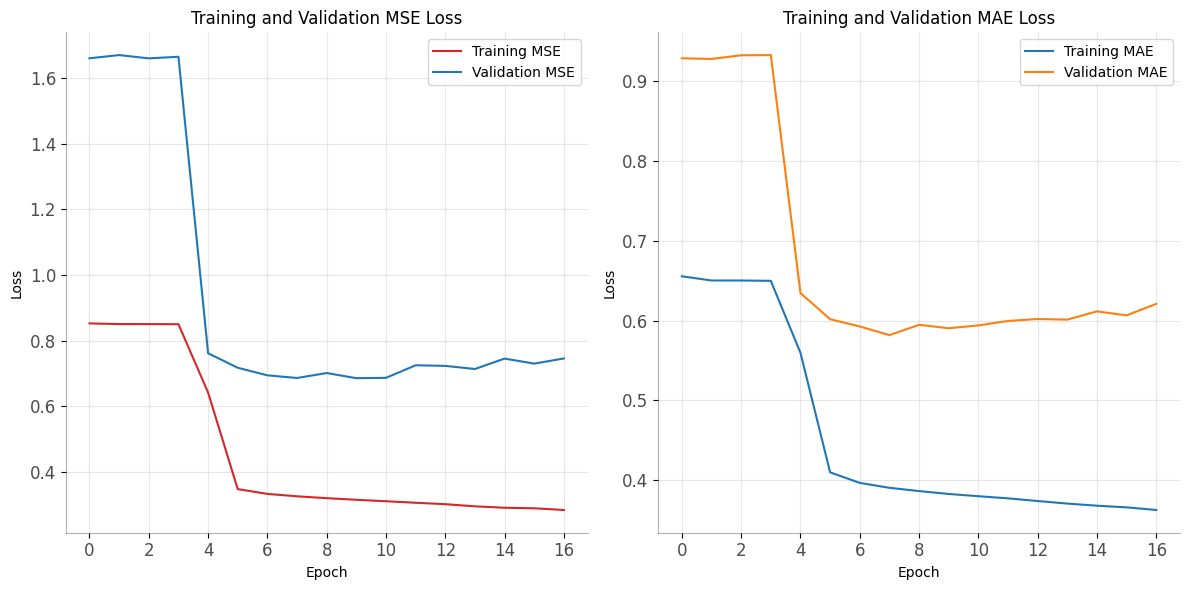

In [16]:
args = (20, timeSeriesNet, train_loader, valid_loader, n_in, n_pred)
# args = (50, 128, 2048, train_HUFL, valid_HUFL)
notebook_launcher(train_valid_loop, args, num_processes=1)

In [17]:
timeSeriesNet.eval()
MSE = nn.MSELoss()
MAE = nn.L1Loss()
batch_test_losses_mse = []
batch_test_losses_mae = []

test_batch = 6 # Flash Llama
test_loader = DataLoader(test_win, batch_size=batch_size, shuffle=True)

with torch.no_grad():
    for test_data in tqdm(test_loader):
        test_inputs, test_next_values = test_data[:, :n_in].to('cuda'), test_data[:, -n_pred:].to('cuda')
        test_pred = timeSeriesNet(test_inputs, n_pred).squeeze()
        mse = MSE(test_pred, test_next_values)
        mae = MAE(test_pred, test_next_values)
        batch_test_losses_mse.append(mse.item())
        batch_test_losses_mae.append(mae.item())
test_mse = np.mean(batch_test_losses_mse)
test_mae = np.mean(batch_test_losses_mae)
print(f'Average testing MSE: {test_mse}')
print(f'Average testing MAE: {test_mae}')

100%|██████████| 54/54 [00:08<00:00,  6.69it/s]

Average testing MSE: 0.5359590743426923
Average testing MAE: 0.5218366870173702


  0%|          | 0/54 [00:00<?, ?it/s]


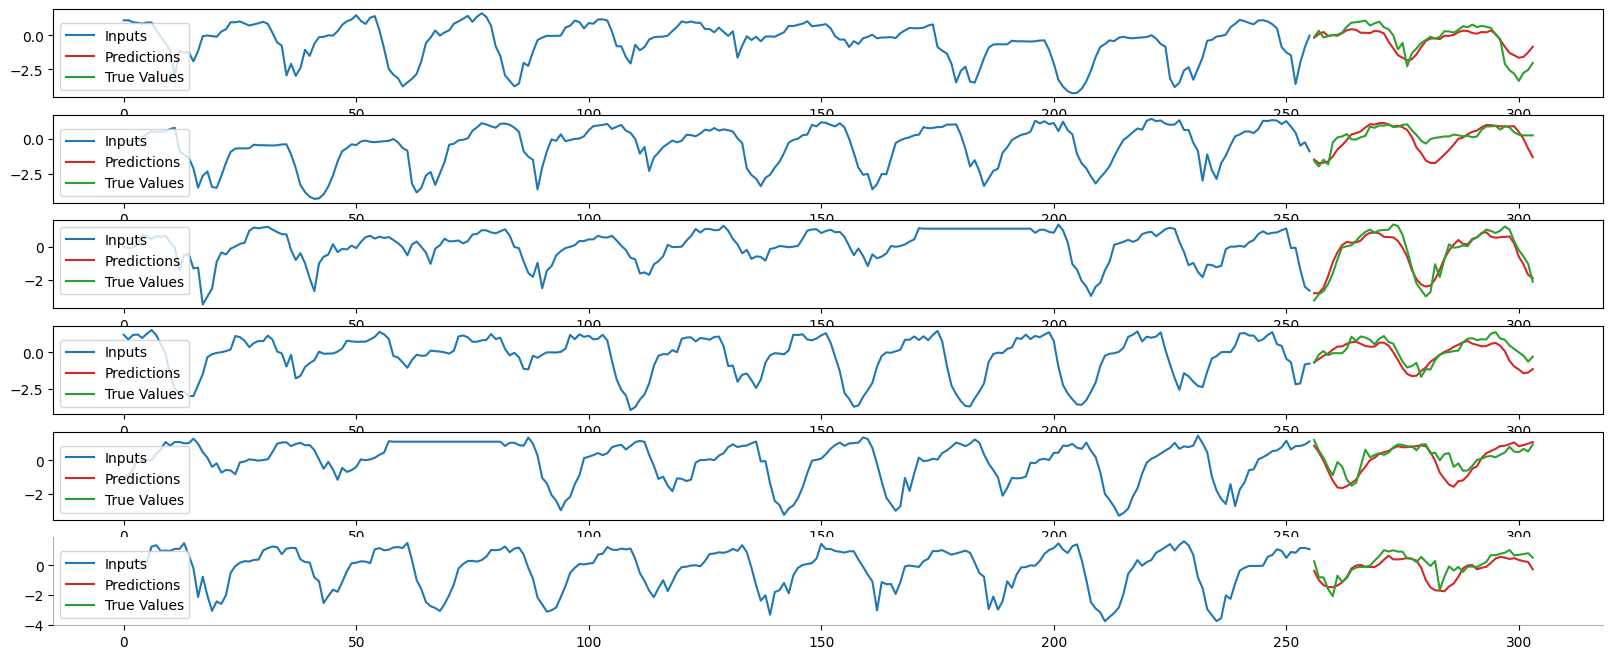

In [21]:
n_in = 256
n_pred = 48
fig, axs = plt.subplots(test_batch, 1, figsize=(20, 8))

with torch.no_grad():
    for test_data in tqdm(test_loader):
        test_inputs, test_next_values = test_data[:, :n_in].to('cuda'), test_data[:, -n_pred:].to('cuda')
        test_pred = timeSeriesNet(test_inputs, n_pred).squeeze()
        
        for idx in range(test_batch):
            axs[idx].plot(np.arange(0, n_in), test_inputs[idx].cpu().numpy(), label='Inputs', color='tab:blue')
            axs[idx].plot(np.arange(n_in, n_in+n_pred), test_pred[idx].cpu().numpy(), label='Predictions', color='tab:red')
            axs[idx].plot(np.arange(n_in, n_in+n_pred), test_next_values[idx].cpu().numpy(), label='True Values', color='tab:green')
            axs[idx].legend()
#     plt.plot(pred, label='Predictions')
#     plt.plot(true_values, label='True values')
#     plt.legend()
#     plt.savefig(f'pred_vs_true({idx}).png', dpi=300, figsize=(12,6))
#     plt.show()
        break

plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)

plt.savefig('/kaggle/working/predictions.png', dpi=300)
plt.show()

In [22]:
# torch.save(timeSeriesNet.state_dict(), 'TinyPatch.pt')
torch.save(timeSeriesNet.state_dict(), 'FlashPatch.pt')

  0%|          | 0/54 [00:00<?, ?it/s]


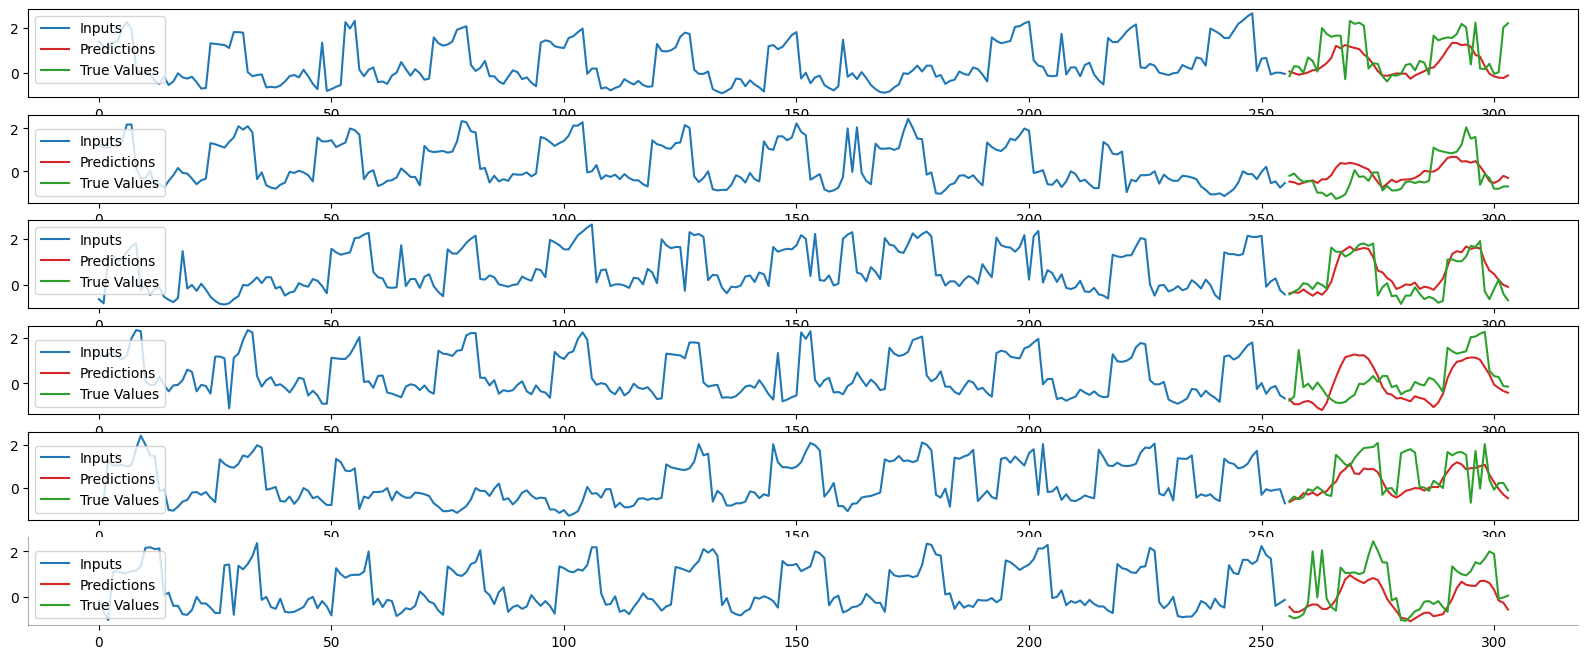

In [25]:
df_lufl = dataset['LUFL']
lufl = torch.Tensor(df_lufl)
lufl = torch.Tensor(scaler.fit_transform(lufl.unsqueeze(dim=1)).squeeze())

num_windows = len(lufl) - window_size + 1

win = torch.zeros(num_windows, window_size)

for i in range(num_windows):
    w = lufl[i:i+window_size]
    win[i] = w

n_in = 256
n_pred = 48
train_size = 0.8
validation_size = 0.1 
test_size = 0.1
window_size = n_in + n_pred  

train_len = int(train_size * len(win))
validation_len = int(validation_size * len(win))
test_len = int(test_size * len(win))

test_win = win[train_len+validation_len:train_len+validation_len+test_len]

test_batch = 6 # Flash Llama
test_loader = DataLoader(test_win, batch_size=batch_size, shuffle=True)

n_in = 256
n_pred = 48
fig, axs = plt.subplots(test_batch, 1, figsize=(20, 8))

with torch.no_grad():
    for test_data in tqdm(test_loader):
        test_inputs, test_next_values = test_data[:, :n_in].to('cuda'), test_data[:, -n_pred:].to('cuda')
        test_pred = timeSeriesNet(test_inputs, n_pred).squeeze()
        
        for idx in range(test_batch):
            axs[idx].plot(np.arange(0, n_in), test_inputs[idx].cpu().numpy(), label='Inputs', color='tab:blue')
            axs[idx].plot(np.arange(n_in, n_in+n_pred), test_pred[idx].cpu().numpy(), label='Predictions', color='tab:red')
            axs[idx].plot(np.arange(n_in, n_in+n_pred), test_next_values[idx].cpu().numpy(), label='True Values', color='tab:green')
            axs[idx].legend()
        break

plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)

plt.savefig('/kaggle/working/predictions_lufl.png', dpi=300)
plt.show()

  0%|          | 0/54 [00:00<?, ?it/s]


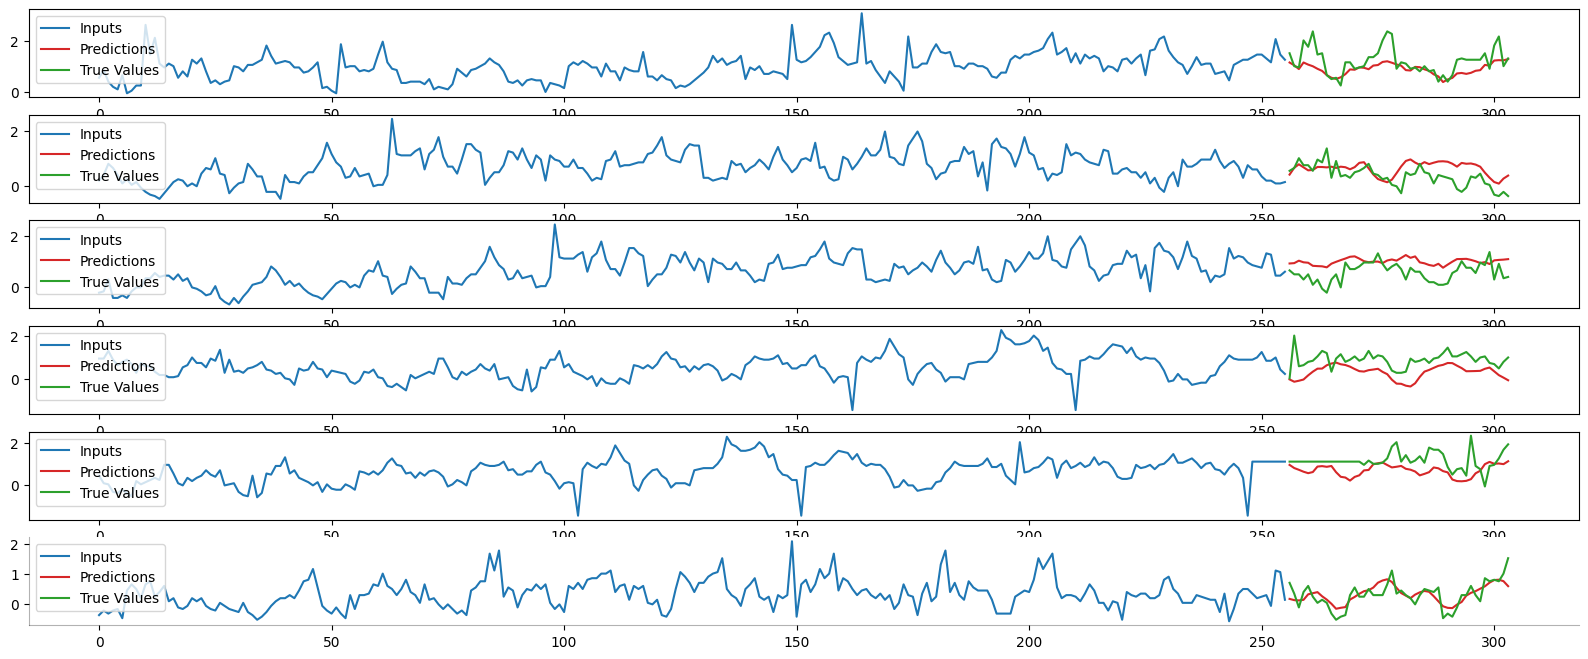

In [26]:
df_lull = dataset['LULL']
lull = torch.Tensor(df_lull)
lull = torch.Tensor(scaler.fit_transform(lull.unsqueeze(dim=1)).squeeze())

num_windows = len(lull) - window_size + 1

win = torch.zeros(num_windows, window_size)

for i in range(num_windows):
    w = lull[i:i+window_size]
    win[i] = w

n_in = 256
n_pred = 48
train_size = 0.8
validation_size = 0.1 
test_size = 0.1
window_size = n_in + n_pred  

train_len = int(train_size * len(win))
validation_len = int(validation_size * len(win))
test_len = int(test_size * len(win))

test_win = win[train_len+validation_len:train_len+validation_len+test_len]

test_batch = 6 # Flash Llama
test_loader = DataLoader(test_win, batch_size=batch_size, shuffle=True)

n_in = 256
n_pred = 48
fig, axs = plt.subplots(test_batch, 1, figsize=(20, 8))

with torch.no_grad():
    for test_data in tqdm(test_loader):
        test_inputs, test_next_values = test_data[:, :n_in].to('cuda'), test_data[:, -n_pred:].to('cuda')
        test_pred = timeSeriesNet(test_inputs, n_pred).squeeze()
        
        for idx in range(test_batch):
            axs[idx].plot(np.arange(0, n_in), test_inputs[idx].cpu().numpy(), label='Inputs', color='tab:blue')
            axs[idx].plot(np.arange(n_in, n_in+n_pred), test_pred[idx].cpu().numpy(), label='Predictions', color='tab:red')
            axs[idx].plot(np.arange(n_in, n_in+n_pred), test_next_values[idx].cpu().numpy(), label='True Values', color='tab:green')
            axs[idx].legend()
        break

plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)

plt.savefig('/kaggle/working/predictions_lufl.png', dpi=300)
plt.show()